# Notebook 06: Smoothing Spline Generalized Additive Models (GAMs)

## About this notebook

This notebook contains a set of baseline linear models created to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` using the small set of valid predictors available in our original dataset (therefore, no engineered features were used here.

## Summary of findings

- Sigmoid scaled `Budget_Start` and `Duration_Start` predictor data sufficiently minimizes skew to provide the best predictive performance amongst our linear models.


- Our two predicted outcome variables, 3-year project `Budget_Change_Ratio` and `Schedule_Change_Ratio`, both exhibit different predictive behavior.


- While our linear models fail to predict `Budget_Change_Ratio` better than a naive model, as is evidenced by negative $R^2$ test score, our `Schedule_Change_Ratio` predictions do moderately well with our best test $R^2$ score exceeding 0.54.


- Of our linear models contained in this notebook, **Ordinary Linear Regression lacks sufficient expressiveness to model our predictors** well and the remaining skew of our data, lack of uniformly distributed residuals, and poor train AND test $R^2$ scores indicate that method is ill suited for our needs.

```
"BASELINE" Linear Regression model results used the following predictors:

    ['Budget_Start', 'Duration_Start']
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.0116
            Test		-0.3509

        Schedule_Change_Ratio

            Training	0.2332
            Test		0.2697
            

"BASELINE+" Linear Regression model using the project Category as one-hot-encoded predictors:

    ['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']
    
    
    R-square scores:
    
        Budget_Change_Ratio

            Training	0.0686
            Test		-2.5340

        Schedule_Change_Ratio

            Training	0.4523
            Test		0.3364

```    

<br>

- On the otherhand, our **smoothing spline GAM model with separately optimized $\lambda$ term penalties for each specific predicted outcome variable `Budget_Change_Ratio` and `Schedule_Change_Ratio`** demonstrated enough improvement in our $R^2$ scores to offer hope that a combination of additional engineered features and a sufficiently expressive model, might give us some form of acceptable predictive performance.

```
"BASELINE+" Smoothing Spline GAM results with optimized term penalties by response variable and a label-encoded `Category` predictor:

    ['Budget_Start', 'Duration_Start', `Category_Code`]
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.8263
            Test		-0.8736

        Schedule_Change_Ratio

            Training	0.5800
            Test		0.5373

```

<br>


# Notebook contents

- **ADD HYPERLINKS TO NOTEBOOK SECTIONS**


In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

import statsmodels.formula.api as sm
from pygam import LinearGAM, s, f

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend, plot_gam_by_predictor


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
filepath_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
filepath_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
filepath_full = '../data/interim/Capital_Projects_clean.csv'

error = None
for filepath in [filepath_train, filepath_test, filepath_full]: 
    if not os.path.isfile(filepath):
        error = 1
        print(
            "ERROR - the following target file does not exist:\n\n\t{}\n"\
            "".format(filepath)
        )

if error is None:
    print("OK - all filepaths point to existing files!")

OK - all filepaths point to existing files!


In [3]:
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)
data_full = pd.read_csv(filepath_full) 

In [4]:
# entries
print(f"Number of dataset records: {len(data_train)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_train['PID'].unique())}")

Number of dataset records: 134
Number of unique projects in dataset: 134


In [5]:
print('{}\t{}'.format(data_train.shape, data_test.shape))

(134, 54)	(15, 54)


In [6]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data_train[col] = pd.to_datetime(data_train[col])
    data_test[col] = pd.to_datetime(data_test[col])

In [7]:
data_train.info()

data_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  134 non-null    int64         
 1   PID                         134 non-null    int64         
 2   Project_Name                134 non-null    object        
 3   Description                 134 non-null    object        
 4   Category                    134 non-null    object        
 5   Borough                     134 non-null    object        
 6   Managing_Agency             134 non-null    object        
 7   Client_Agency               134 non-null    object        
 8   Phase_Start                 134 non-null    object        
 9   Current_Project_Years       134 non-null    float64       
 10  Current_Project_Year        134 non-null    int64         
 11  Design_Start                134 non-null    datetime64[ns]

,Unnamed: 0,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,...,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2,attribute_km3_label
0,0,204,Edgewood Triangle Roadway Reconstruction,Reconstruct roadway and extend storm and sanit...,Streets and Roadways,Queens,DDC,DOT,2-Design,6.55,...,0.46,-0.41,12.32,10.59,4,6.10,4.54,6.02,3.01,0
1,1,577,Bronx Public School 19 Addition,Design and construction of a new school,Schools,Bronx,SCA,DOE,2-Design,2.94,...,-12.40,-3.70,8.39,-1.15,0,0.00,-0.01,-11.32,-2.94,1
2,2,664,"NEW STRM SWR & WM REPLACEMENT IN ACACIA AVE, ETC.",New Strom Sewer extension & Water Main replace...,Sewers,Staten Island,DDC,DEP,3-Construction Procurement,4.75,...,-0.47,-0.43,16.50,11.85,5,5.16,3.84,4.00,0.82,0


## Subset and scale data for X and y frames

In [8]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Bridges',
    'Ferries',
    'Industrial_Development',
    'Parks',
    'Sanitation',
    'Schools',
    'Sewers',
    'Streets_and_Roadways',
    'Wastewater_Treatment',
    'Water_Supply',
    'Category_Code',
    'umap_descr_2D_embed_1',
    'umap_descr_2D_embed_2',
    'umap_attributes_2D_embed_1',
    'umap_attributes_2D_embed_2',
    'attribute_clustering_label',
    'ae_descr_embed_1',
    'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
    'attribute_km3_label'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

X_train, y_train = data_train[X_cols], data_train[y_cols]
X_test, y_test = data_test[X_cols], data_test[y_cols]

In [9]:
print('{}\t{}'.format(X_train.shape, X_test.shape))
print('{}\t{}'.format(y_train.shape, y_test.shape))

(134, 23)	(15, 23)
(134, 2)	(15, 2)


In [10]:
X_train.info()
print()
y_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Budget_Start                134 non-null    float64
 1   Duration_Start              134 non-null    int64  
 2   Bridges                     134 non-null    int64  
 3   Ferries                     134 non-null    int64  
 4   Industrial_Development      134 non-null    int64  
 5   Parks                       134 non-null    int64  
 6   Sanitation                  134 non-null    int64  
 7   Schools                     134 non-null    int64  
 8   Sewers                      134 non-null    int64  
 9   Streets_and_Roadways        134 non-null    int64  
 10  Wastewater_Treatment        134 non-null    int64  
 11  Water_Supply                134 non-null    int64  
 12  Category_Code               134 non-null    int64  
 13  umap_descr_2D_embed_1       134 non

,Budget_Start,Duration_Start,Bridges,Ferries,Industrial_Development,Parks,Sanitation,Schools,Sewers,Streets_and_Roadways,...,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2,attribute_km3_label
count,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,...,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00
mean,"103,617,509.14","1,943.45",0.12,0.01,0.12,0.02,0.04,0.11,0.13,0.18,...,-0.66,0.19,10.00,9.85,3.08,2.99,2.22,0.00,-0.00,0.63
std,"213,833,628.68",636.18,0.33,0.12,0.33,0.15,0.19,0.32,0.33,0.38,...,5.47,2.98,6.08,4.75,1.89,2.31,1.72,5.44,3.62,0.63
min,"813,000.00",663.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-13.29,-9.86,-2.88,-2.13,-1.00,0.00,-0.01,-11.32,-6.85,0.00
25%,"32,020,250.00","1,502.25",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-2.76,-1.80,6.95,8.97,2.00,0.78,0.57,-3.13,-2.94,0.00
50%,"46,525,815.50","1,890.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.30,0.29,11.77,10.89,3.00,2.87,2.14,1.11,-0.12,1.00
75%,"77,134,000.00","2,247.75",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.94,2.68,16.02,12.09,5.00,4.88,3.61,4.16,2.66,1.00
max,"1,910,339,114.55","4,360.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,12.30,10.83,17.74,15.59,5.00,11.10,8.21,12.96,8.55,2.00


In [11]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X_train)[2:]


# # Standardize both X_train and X_test data, fitting X_train as the
# # scaler for both
# scaler = StandardScaler
# scale_before_func = None
# scale_after_func = None
# reapply_scaler = False


# X_train_std, Scaler_std = scale_features(
#     X_train, X_train,
#     exclude_scale_cols,
#     scaler,
#     scale_before_func,
#     scale_after_func,
#     reapply_scaler,
# )

# X_test_std, _ = scale_features(
#     X_train, X_test,
#     exclude_scale_cols,
#     scaler,
#     scale_before_func,
#     scale_after_func,
#     reapply_scaler,
# )


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

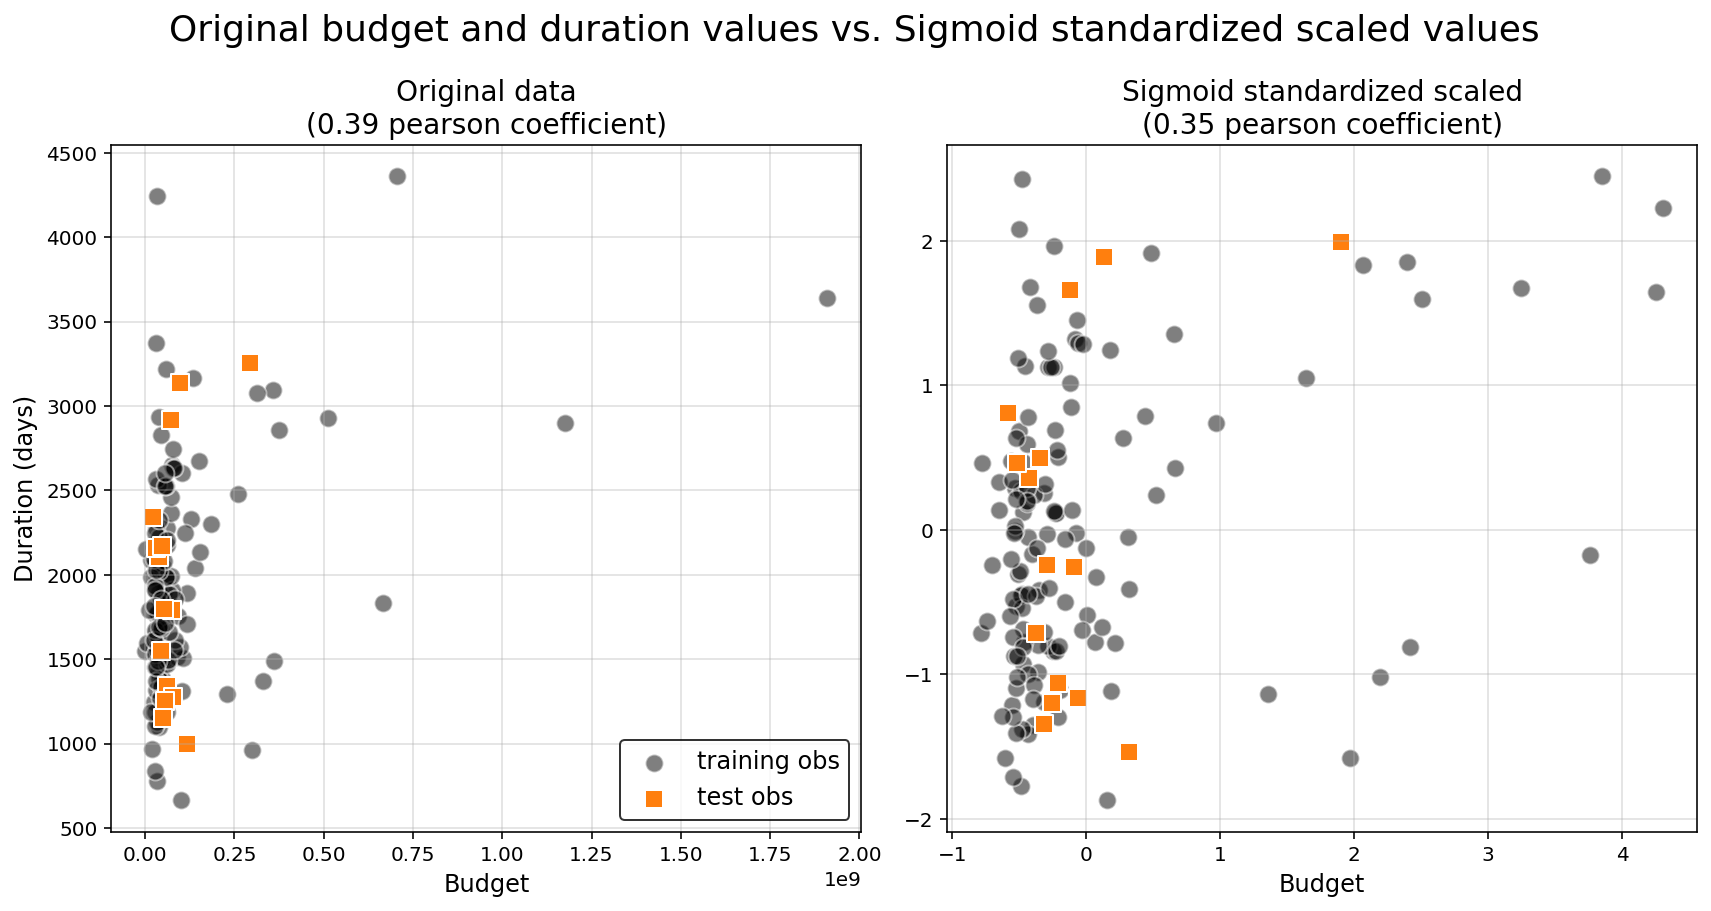

In [12]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

**FINDINGS**:

By visualizing our `Budget_Start` and `Duration_Start` predictors above, we can see a large skew with clear outliers in the original unscaled data. By applying standardization to the these predictors, as we have illustrated in the upper righthand plot, we have set both variables to the same scale. However, standardizing has not alleviated the skewness of our data or helped with our outlying datapoints. 

Therefore, we have also applied a sigmoid transformation to the data and re-standardized, as is shown in the lower righthand plot. This sigmoid transformation has helped to alleviate the skew of our data, and it has also helped to more evenly distrubute all of our data points, drawing outliers far closer to the center of the distribution.

**Now we will fit a "Baseline" linear regression model on our scaled datasets to see which performs best.**

## Linear GAM model, using "Baseline+" predictors

In [13]:
list(X_train)

['Budget_Start',
 'Duration_Start',
 'Bridges',
 'Ferries',
 'Industrial_Development',
 'Parks',
 'Sanitation',
 'Schools',
 'Sewers',
 'Streets_and_Roadways',
 'Wastewater_Treatment',
 'Water_Supply',
 'Category_Code',
 'umap_descr_2D_embed_1',
 'umap_descr_2D_embed_2',
 'umap_attributes_2D_embed_1',
 'umap_attributes_2D_embed_2',
 'attribute_clustering_label',
 'ae_descr_embed_1',
 'ae_descr_embed_2',
 'pca_descr_embed_1',
 'pca_descr_embed_2',
 'attribute_km3_label']

In [14]:
features = [
    'Budget_Start',
    'Duration_Start',
    'Category_Code',
]

print(
    '\nThis smoothing spline GAM uses the same predictors as our '\
    '"BASELINE+" regression model,\nexcept Category is label-encoded '\
    'instead of one-hot-encoded:'\
    '\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM, sigmoid standarized data, with categories'

terms = s(0) + s(1) + f(2)

model_GAM0 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


print_model_results(model_GAM0)


This smoothing spline GAM uses the same predictors as our "BASELINE+" regression model,
except Category is label-encoded instead of one-hot-encoded:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM, sigmoid standarized data, with categories


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.5426
		Test		-1.1546

	Schedule_Change_Ratio

		Training	0.6628
		Test		0.5840





**FINDINGS:**

Here we can see that we stand to benefit from the added expressiveness of a smoothing spline class of linear model, as is illustrated by the improved $R^2$ results shown above. However, while our `Schedule_Change_Ratio` predictions have improved from $R^2=0.34$ to $R^2=0.58$, our `Budget_Change_Ratio` test $R^2$ score is still extremely negative. However, the smoothing spline GAM does appear to have fitted the training set with a `Budget_Change_Ratio` $R^2$ score of 0.54, which is somewhat promising. Now, if only we can improve on this to find a model that generalizes when to unseen data.

### Use gridsearch to find optimal value $\lambda$ for each term in the smoothing spline GAM model

- Here we treat each y output independently, partly because PyGam's Linear GAM will not fit a multi-output model, but mostly because each y output behaves differently and we have found that different $\lambda$ values are required to optimize both output


- We also use PyGam's native `gridsearch` method to choose our values $\lambda$.
    - Because there are so few instances of some project categories, traditional cross-validation using k-splits creates instances where some train instances are missing one or two categories
    - When that occurs, PyGam cannot fit a coefficient to that category and generates an error.
    

In [15]:
terms = s(0) + s(1) + f(2)

# generate list of lambdas against which to perform gridsearch for
# each outcome variable and each of our 3 input predictors
lam_list = np.logspace(-3, 5, 10)
lams = [lam_list] * 3

# fit GAM to predict budget change ratio 
gam1 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Budget_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam1.gridsearch(
    X_train_std_sig[features], y_train['Budget_Change_Ratio'],
    lam=lams
)

# fit GAM to predict schedule change ratio
gam2 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam2.gridsearch(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio'],
    lam=lams
)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:18 Time:  0:00:18
100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [16]:
%%capture --no-stdout

print(
    '\nGAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:\n'
)
gam1.summary()

print(
    '\n\n\nGAM gridsearch results for SCHEDULE_CHANGE_RATIO prediction model:\n'
)
gam2.summary()


GAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7569
Link Function:                     IdentityLink Log Likelihood:                                  -419.7587
Number of Samples:                          134 AIC:                                              879.0312
                                                AICc:                                             886.2739
                                                GCV:                                               11.5842
                                                Scale:                                              8.7077
                                                Pseudo R-Squared:            

# ADD INTERPRETATION

In [17]:
print(
    '\nThese smoothing spline GAMs have been fit using the optimal lambda penalties '\
    'for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO '\
    'predictions, the other for SCHEDULE_CHANGE_RATIO predictions.\n\n'\
    'The predictors used are:\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties'

terms = s(0, lam=0.001) + s(1, lam=100000) + f(2, lam=215.4435)

model_GAM1 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)

print_model_results(model_GAM1)

model_descr = 'Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RATIO optimal penalties'

terms = s(0, lam=100000) + s(1, lam=27.8256) + f(2, lam=3.5938)

model_GAM2 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


# generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
# )

print_model_results(model_GAM2)


These smoothing spline GAMs have been fit using the optimal lambda penalties for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO predictions, the other for SCHEDULE_CHANGE_RATIO predictions.

The predictors used are:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.8263
		Test		-0.8736

	Schedule_Change_Ratio

		Training	0.3532
		Test		0.0337




MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RAT

# ADD INTERPRETATION

# Visualize optimized baseline smoothing spline GAM predictions and contribution by predictor

In [18]:
y_pred_train = np.hstack(
    [
        model_GAM1['predictions']['train'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_GAM1['predictions']['test'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

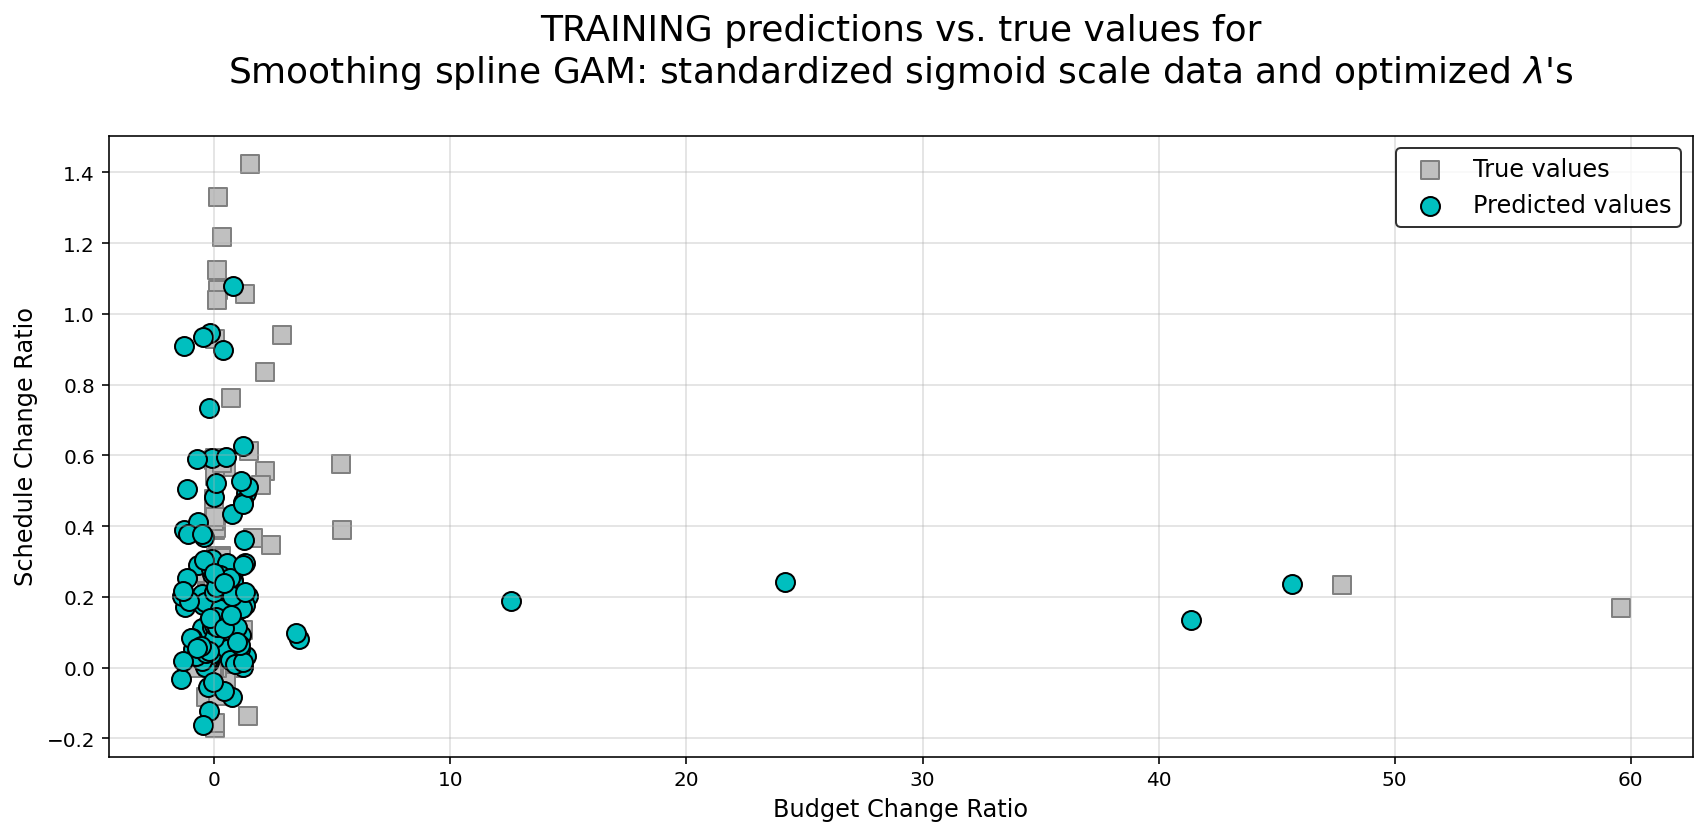

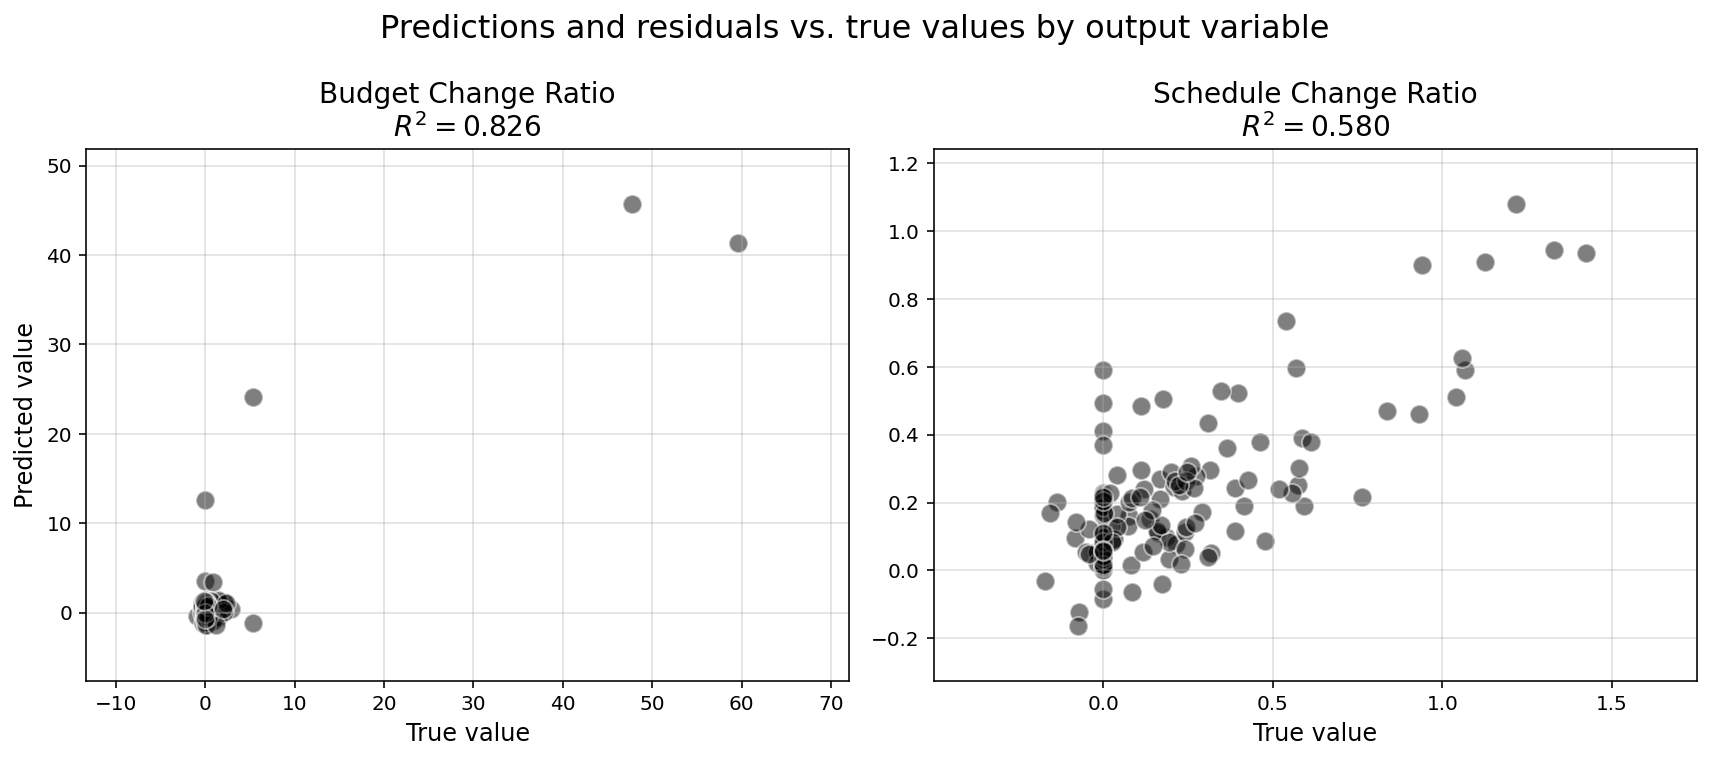

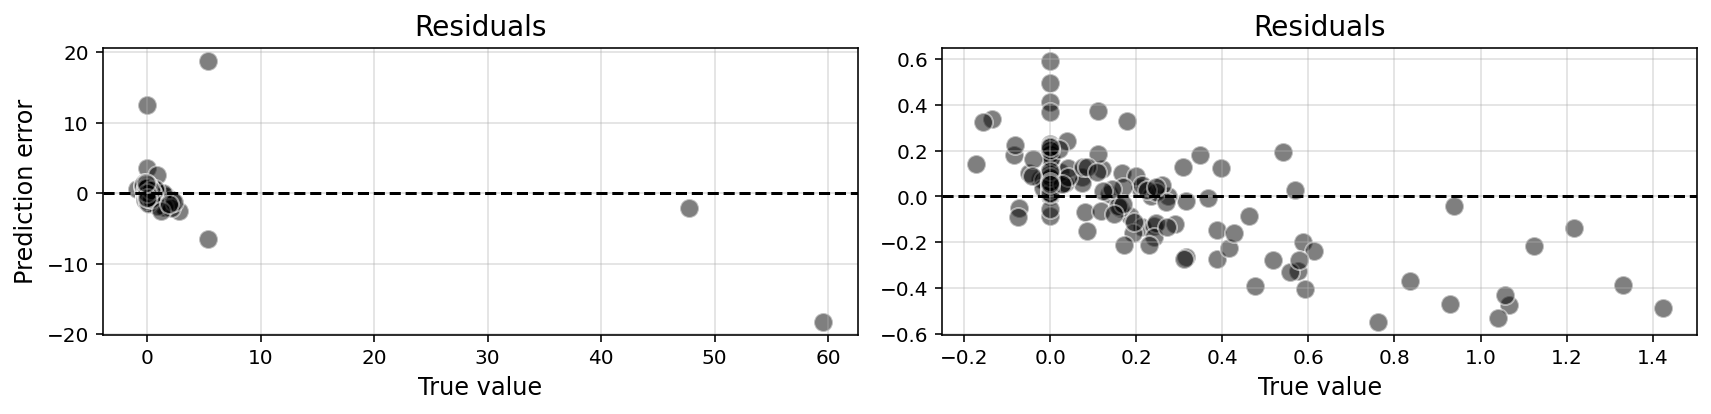

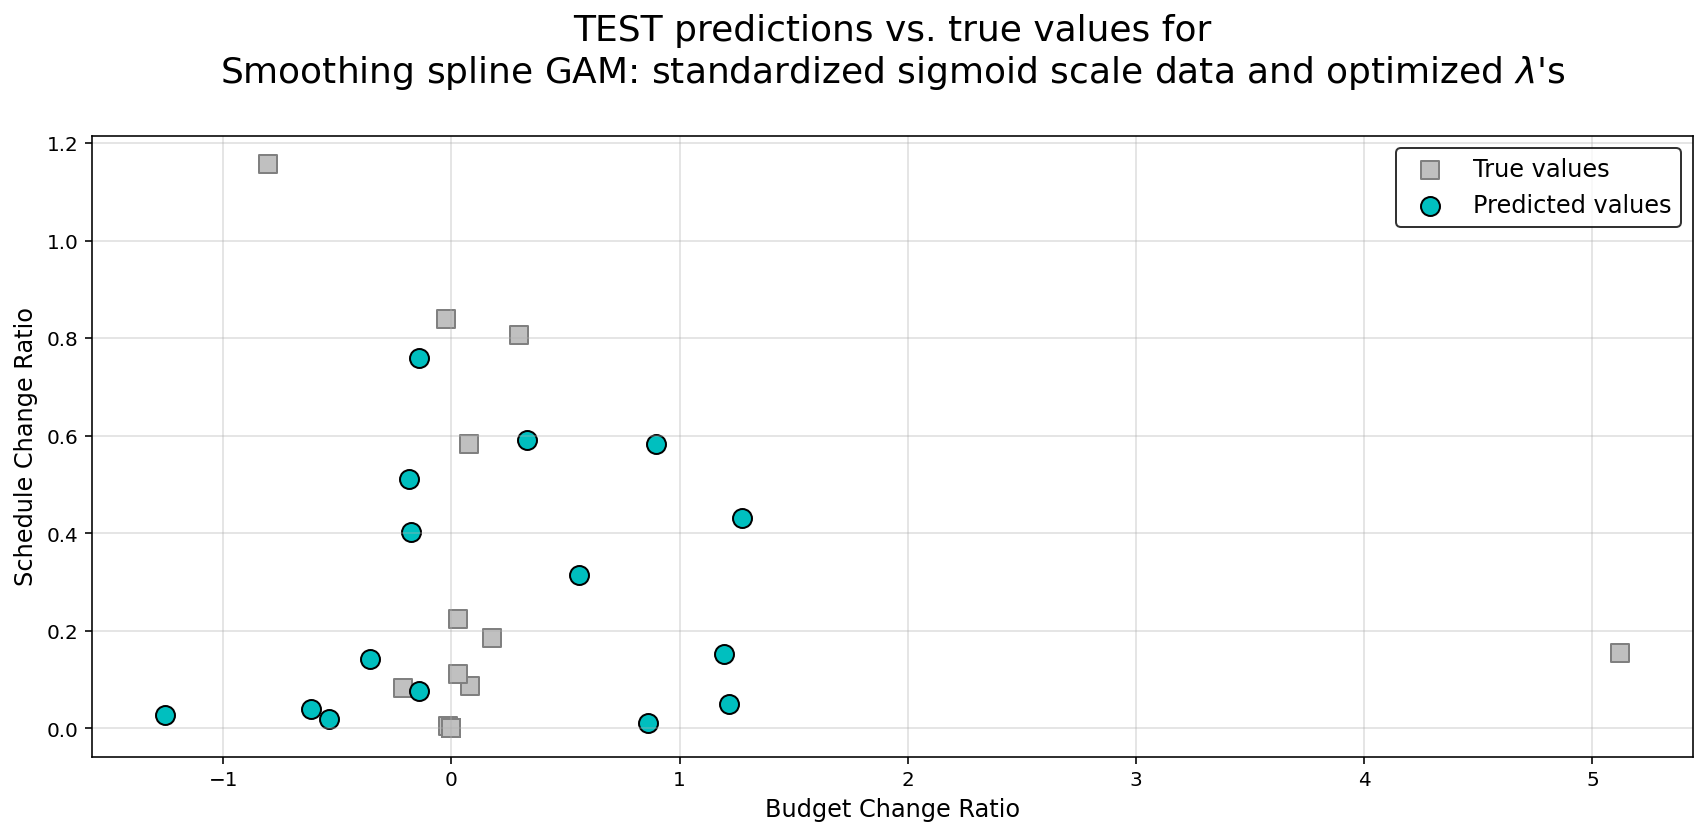

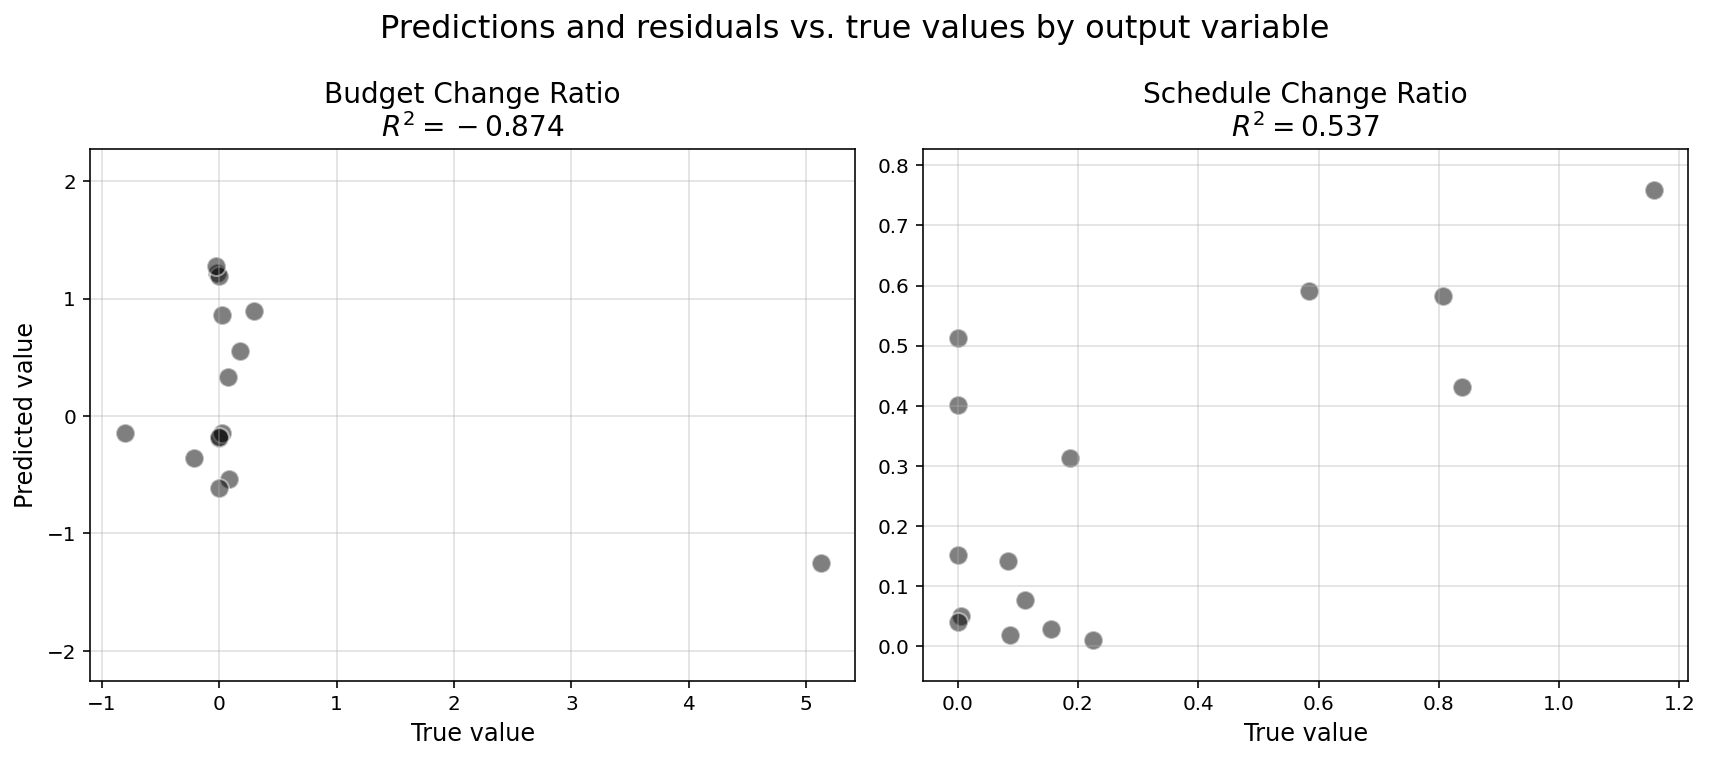

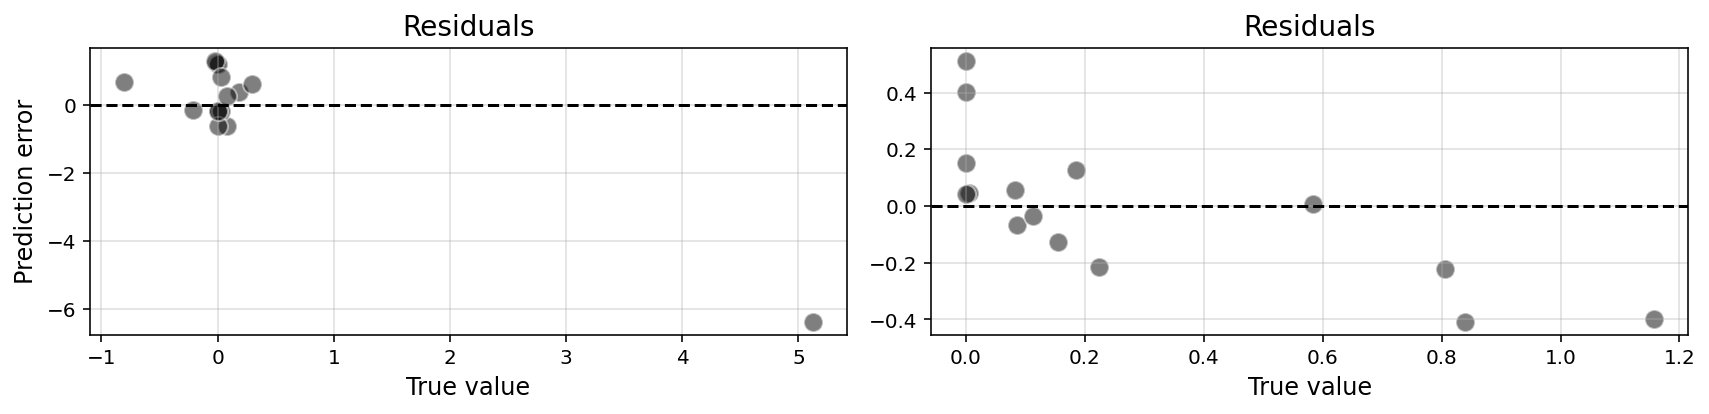

In [19]:
model_descr = "Smoothing spline GAM: standardized sigmoid scale data and optimized $\lambda$'s"
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

# ADD INTERPRETATION

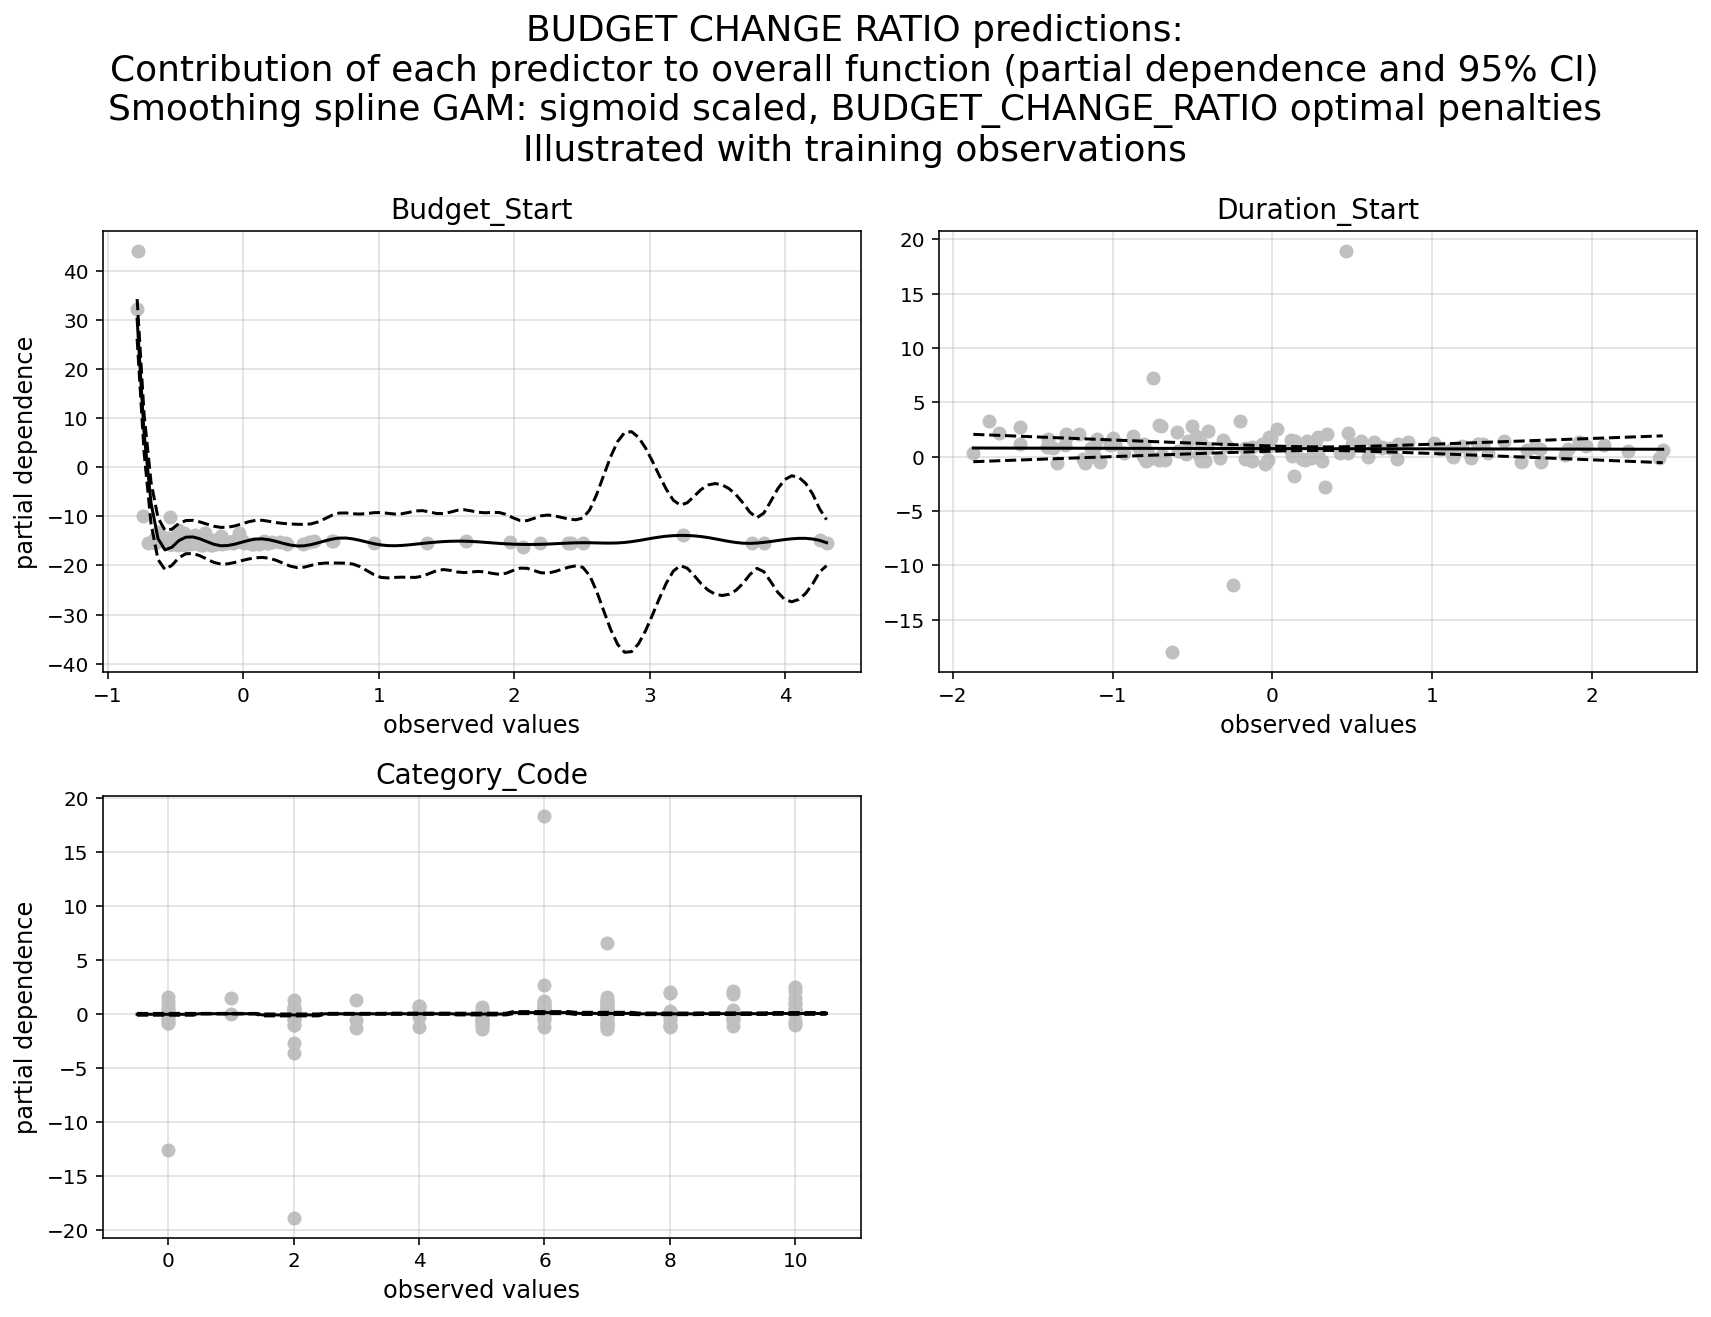

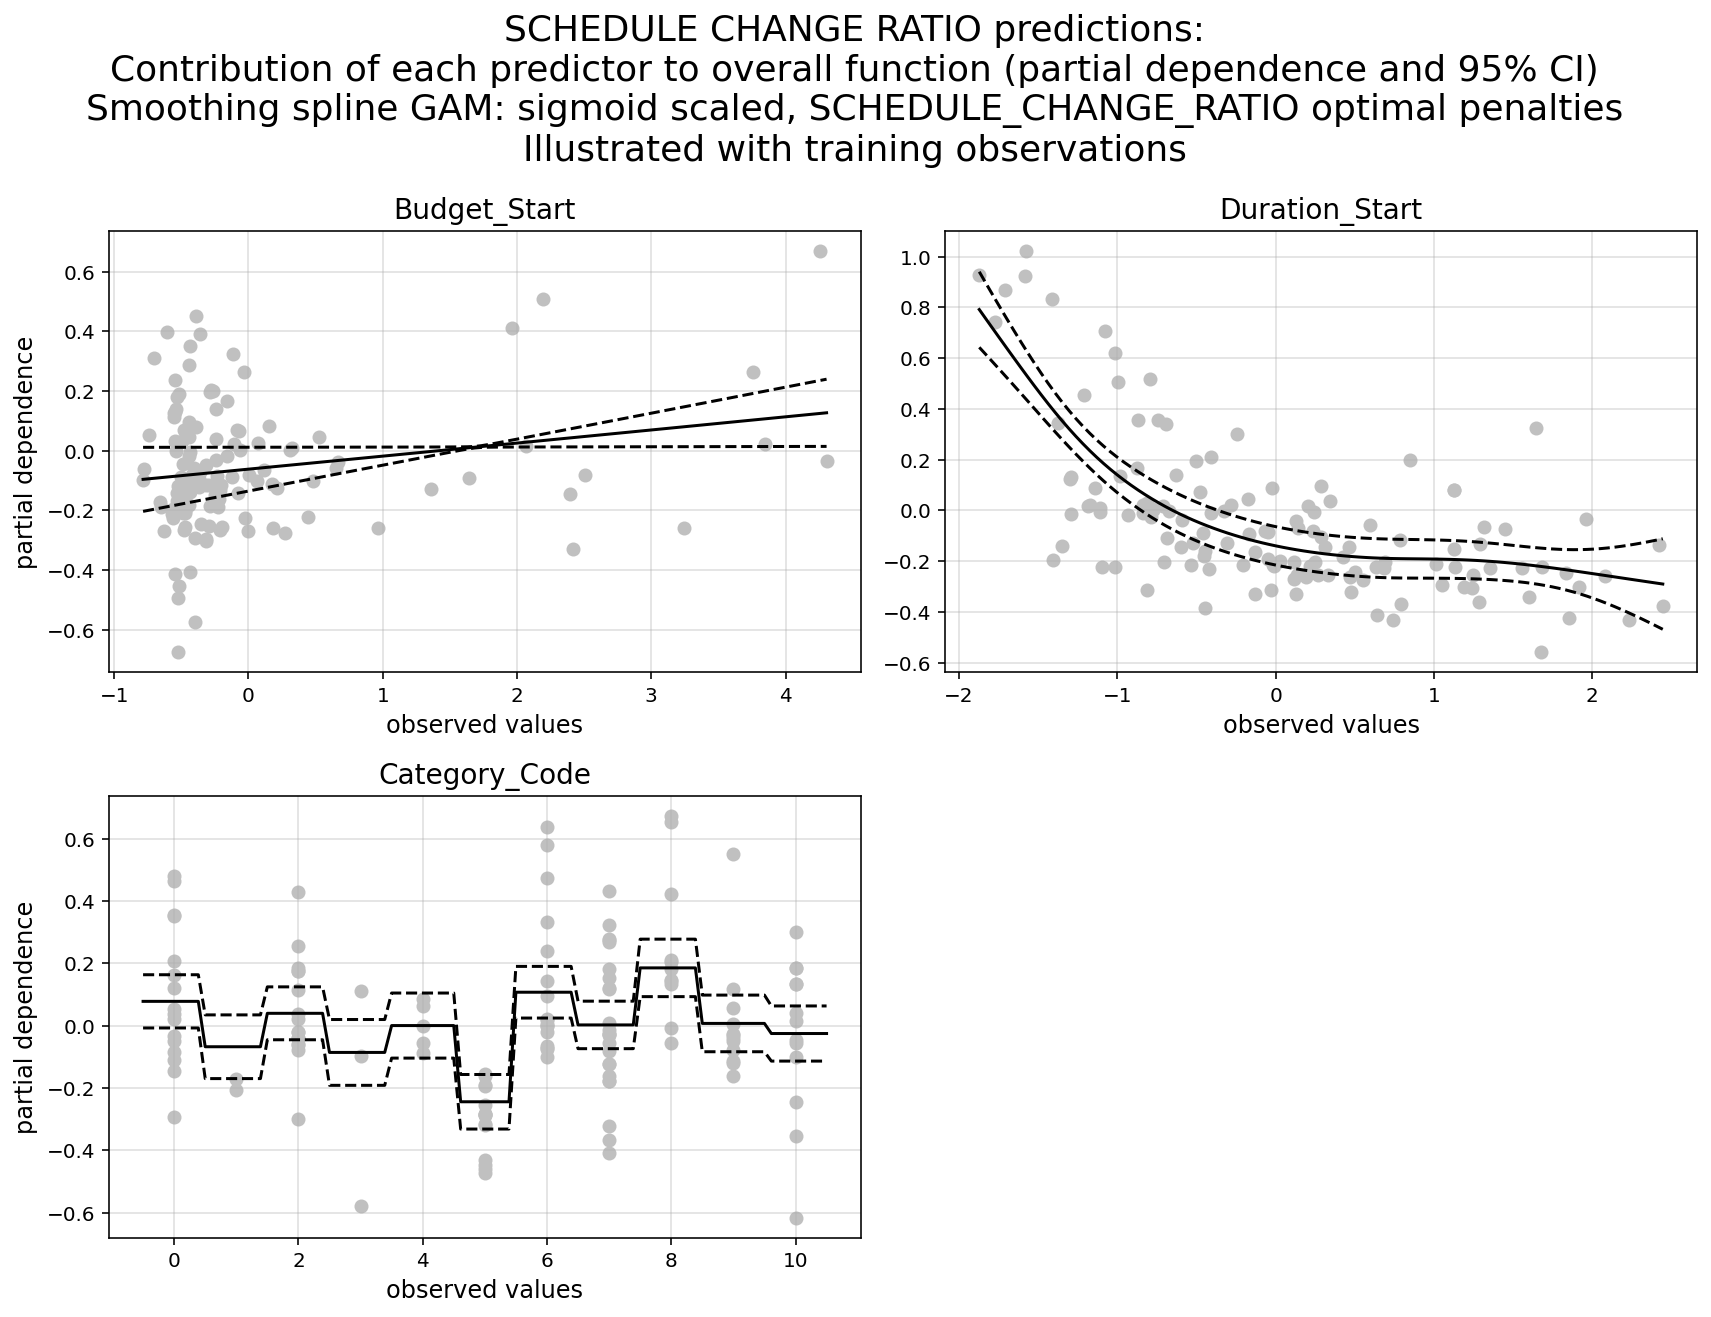

In [20]:
plot_gam_by_predictor(
    model_dict=model_GAM1, model_index=0,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

print()
plot_gam_by_predictor(
    model_dict=model_GAM2, model_index=1,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

# ADD INTERPRETATION & CONCLUSIONS

In [92]:
features = [
    'Budget_Start',
    'Duration_Start',
    'Category_Code',
#     'attribute_km3_label',
    'attribute_clustering_label',
#     'umap_descr_2D_embed_1',
#     'umap_descr_2D_embed_2',
#     'umap_attributes_2D_embed_1',
#     'umap_attributes_2D_embed_2',
#     'ae_descr_embed_1',
#     'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
]

print(
    '\nThis smoothing spline GAM uses the same predictors as our '\
    '"BASELINE+" regression model,\nexcept Category is label-encoded '\
    'instead of one-hot-encoded:'\
    '\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM, sigmoid standarized data, with categories'

# terms = s(0) + s(1) + f(2)

# terms = s(0) + s(1) + f(2) + f(3)

terms = s(0) + s(1) + f(2) + f(3) + s(4) + s(5)

# terms = s(0) + s(1) + s(2) + s(3)

# terms = s(0) + s(1) + s(2) + s(3) + s(4) + s(5)

# terms = s(0) + s(1) + f(2) + s(3) + s(4)

# terms = s(0) + s(1) + f(2) + s(3) + s(4) + s(5) + s(6)


model_GAM0 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


print_model_results(model_GAM0)


This smoothing spline GAM uses the same predictors as our "BASELINE+" regression model,
except Category is label-encoded instead of one-hot-encoded:

	['Budget_Start', 'Duration_Start', 'Category_Code', 'attribute_clustering_label', 'pca_descr_embed_1', 'pca_descr_embed_2']



MODEL SUMMARY:
Smoothing spline GAM, sigmoid standarized data, with categories


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + f(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + f(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.6010
		Test		-4.3875

	Schedule_Change_Ratio

		Training	0.7828
		Test		0.4375





In [ ]:
features1 = [
    'Budget_Start',
    'Duration_Start',
#     'attribute_km3_label',
#     'attribute_clustering_label',
#     'umap_descr_2D_embed_1',
#     'umap_descr_2D_embed_2',
    'umap_attributes_2D_embed_1',
    'umap_attributes_2D_embed_2',
#     'ae_descr_embed_1',
#     'ae_descr_embed_2',
#     'pca_descr_embed_1',
#     'pca_descr_embed_2',
]


terms1 = s(0) + s(1) + s(2) + s(3)

features2 = [
    'Budget_Start',
    'Duration_Start',
    'attribute_clustering_label',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
]

terms2 = s(0) + s(1) + f(2) + s(3) + s(4)

# generate list of lambdas against which to perform gridsearch for
# each outcome variable and each of our 3 input predictors
lam_list = np.logspace(-3, 5, 10)
lams1 = [lam_list] * 4
lams2 = [lam_list] * 5

# fit GAM to predict budget change ratio 
gam1 = LinearGAM(terms1).fit(
    X_train_std_sig[features1], y_train['Budget_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam1.gridsearch(
    X_train_std_sig[features1], y_train['Budget_Change_Ratio'],
    lam=lams1
)

# fit GAM to predict schedule change ratio
gam2 = LinearGAM(terms2).fit(
    X_train_std_sig[features2], y_train['Schedule_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam2.gridsearch(
    X_train_std_sig[features2], y_train['Schedule_Change_Ratio'],
    lam=lams2
)

100% (10000 of 10000) |##################| Elapsed Time: 0:04:50 Time:  0:04:50
  8% (8797 of 100000) |#                 | Elapsed Time: 0:04:37 ETA:   0:48:21

In [ ]:
%%capture --no-stdout

print(
    '\nGAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:\n'
)
gam1.summary()

print(
    '\n\n\nGAM gridsearch results for SCHEDULE_CHANGE_RATIO prediction model:\n'
)
gam2.summary()

In [ ]:
print(
    '\nThese smoothing spline GAMs have been fit using the optimal lambda penalties '\
    'for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO '\
    'predictions, the other for SCHEDULE_CHANGE_RATIO predictions.\n\n'\
    'The predictors used are:\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties'

terms = s(0, lam=0.001) + s(1, lam=100000) + f(2, lam=215.4435)

model_GAM1 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)

print_model_results(model_GAM1)

model_descr = 'Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RATIO optimal penalties'

terms = s(0, lam=100000) + s(1, lam=27.8256) + f(2, lam=3.5938)

model_GAM2 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


# generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
# )

print_model_results(model_GAM2)

In [ ]:
y_pred_train = np.hstack(
    [
        model_GAM1['predictions']['train'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_GAM1['predictions']['test'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

In [ ]:
model_descr = "Smoothing spline GAM: standardized sigmoid scale data and optimized $\lambda$'s"
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

In [ ]:
plot_gam_by_predictor(
    model_dict=model_GAM1, model_index=0,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

print()
plot_gam_by_predictor(
    model_dict=model_GAM2, model_index=1,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)